In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import keras
import tensorflow
import sklearn
from matplotlib import pyplot as plt
import sys
import surfboard
from surfboard.feature_extraction import extract_features

Using TensorFlow backend.


In [2]:
#Misc. adjustments
pd.set_option('max_colwidth', 200)

In [3]:
#Listing files
filelist = os.listdir("Source")

#Read files into pandas
source = pd.DataFrame(filelist)

#Rename file name column
source = source.rename(columns={0:'file'})

#Display files
source

,file
0,03-01-06-01-02-02-02.wav
1,03-01-05-01-02-01-16.wav
2,03-01-08-01-01-01-14.wav
3,03-01-06-01-02-02-16.wav
4,03-01-05-01-02-01-02.wav
...,...
1436,03-01-08-02-02-01-19.wav
1437,03-01-02-02-01-01-23.wav
1438,03-01-02-01-02-01-23.wav
1439,03-01-08-01-01-01-19.wav


In [4]:
#Extraction of variables from filenames
speaker_id = []
speaker_emotion = []

for i in range (0, len(source)):
    id = source["file"][i][18:20]
    emotion = source["file"][i][6:8]
    if id[0:1] == "0":
        speaker_id.append(id[1])
    else:
        speaker_id.append(id)
    
    if emotion[0:1] == "0":
        if emotion[1] == "2":
            speaker_emotion.append("1")
        else:
            speaker_emotion.append(emotion[1])
    else:
        speaker_emotion.append(emotion)
    
#Adding variables to dataframe
source["id"] = speaker_id
source["emotion"] = speaker_emotion

source

,file,id,emotion
0,03-01-06-01-02-02-02.wav,2,6
1,03-01-05-01-02-01-16.wav,16,5
2,03-01-08-01-01-01-14.wav,14,8
3,03-01-06-01-02-02-16.wav,16,6
4,03-01-05-01-02-01-02.wav,2,5
...,...,...,...
1436,03-01-08-02-02-01-19.wav,19,8
1437,03-01-02-02-01-01-23.wav,23,1
1438,03-01-02-01-02-01-23.wav,23,1
1439,03-01-08-01-01-01-19.wav,19,8


In [5]:
#Create training & valuation dataframes
train = pd.DataFrame()
val = pd.DataFrame()

for i in range (1, 25):
    tmp = source[(source.id==str(i)) & (source.emotion=="1")]
    train_tmp = tmp.sample(6)
    val = val.append(tmp.drop(train_tmp.index))
    train = train.append(train_tmp)

train = train.reset_index()
train.file = os.path.join(sys.path[0], "Source/") + train.file 
val = val.reset_index()
val.file = os.path.join(sys.path[0], "Source/") + val.file 

train_files = train.file.tolist()
val_files = val.file.tolist()

In [6]:
#Feature extraction function using surfboard
def feature_extract(files):
    features = surfboard.feature_extraction.extract_features_from_paths(files, ["mfcc", 'f0_statistics', 'formants'], statistics_list=['mean'], sample_rate=44100)
    return features

In [7]:
#Extract features
features_train = feature_extract(train_files)
features_val = feature_extract(val_files)

Extracting features from paths...: 100%|██████████| 144/144 [00:34<00:00,  4.13it/s]


In [8]:
#Create feature maps
X_train = np.array(features_train)
X_val = np.array(features_val)

In [9]:
#Create classification maps
y_train = np.array(train["id"])
y_val = np.array(val["id"])

In [10]:
#Encoding classficiations
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))

In [11]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
#X_test = ss.transform(X_test)

In [12]:
#Create Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 30 classes
model = Sequential()
model.add(Dense(19, input_shape=(19,), activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(24, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [13]:
#Train Neural Network
history = model.fit(X_train, y_train, batch_size=256, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop], verbose = 0)

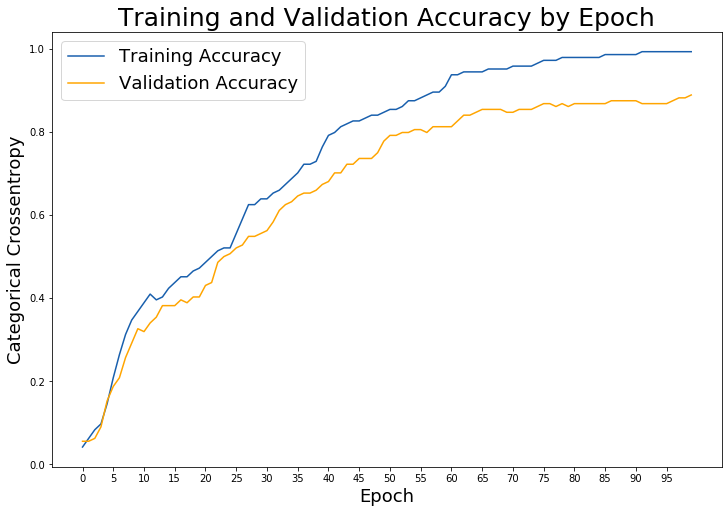

In [14]:
# Check train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']# Set figure size.
plt.figure(figsize=(12, 8))# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);